### Notebook from : https://www.kaggle.com/code/jiaowoguanren/sars-cov-2-ct-scan-dataset-classification-tf-0-99

In [175]:
%pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import pathlib, splitfolders
import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *

from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import  ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

from tensorflow.keras.models import load_model


# USE OF SARSCOV2-CTSCAN-DATASET

In [189]:
epochs = 20
batch_size = 32
img_height, img_width = 300, 300
input_shape = (img_height, img_width, 3)

def create_data_binary(data_bs):
    data_bs = pathlib.Path(data_bs)
    splitfolders.ratio(data_bs, output='sarscov2-ctscan-dataset-splitted/', seed=1234, ratio=(0.7, 0.15, 0.15), group_prefix=None)
    data_gen = ImageDataGenerator(rescale=1.0 / 255)
    train_ds = data_gen.flow_from_directory('sarscov2-ctscan-dataset-splitted/train/', target_size=(img_height, img_width),
                                            class_mode='binary', batch_size=batch_size, subset='training')
    val_ds = data_gen.flow_from_directory('sarscov2-ctscan-dataset-splitted/val/', target_size=(img_height, img_width),
                                          class_mode='binary', batch_size=batch_size, shuffle=False)
    test_ds = data_gen.flow_from_directory('sarscov2-ctscan-dataset-splitted/test/', target_size=(img_height, img_width),
                                          class_mode='binary', batch_size=batch_size, shuffle=False)
    return train_ds, val_ds, test_ds


train_data, val_data, test_data = create_data_binary('sarscov2-ctscan-dataset/')

Copying files: 2481 files [00:01, 2044.85 files/s]


Found 1736 images belonging to 2 classes.
Found 371 images belonging to 2 classes.
Found 374 images belonging to 2 classes.


# USE OF COVID-CT-master DATASET

In [178]:
epochs = 20
batch_size = 32
img_height, img_width = 150, 150
input_shape = (img_height, img_width, 3)

data_gen = ImageDataGenerator(rescale=1.0 / 255)

"""
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
"""
                                  
train_data = data_gen.flow_from_directory("COVID-CT-master/Dataset/train/",
                                          target_size=(img_height, img_width),
                                          batch_size = batch_size,
                                          class_mode = 'binary',
                                          subset='training')
                                         
test_data = data_gen.flow_from_directory("COVID-CT-master/Dataset/test/",
                                          target_size=(img_height, img_width),
                                          batch_size = batch_size,
                                          class_mode = 'binary')

val_data = data_gen.flow_from_directory("COVID-CT-master/Dataset/val/",
                                          target_size=(img_height, img_width),
                                          batch_size = batch_size,
                                          class_mode = 'binary',
                                          shuffle=False)

Found 425 images belonging to 2 classes.
Found 203 images belonging to 2 classes.
Found 118 images belonging to 2 classes.


### Base Model CNN

In [190]:
model_base = tf.keras.Sequential(
    [
        Conv2D(32, (3 * 3), padding='same', input_shape = input_shape),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(2, padding='same'),

        Conv2D(32, (3 * 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(2, padding='same'),
        Dropout(0.3),

        Conv2D(32, (3 * 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(2, padding='same'),
        Dropout(0.3),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ]
)

model_base.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Define the callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True, save_weights_only=True)

history = model_base.fit(train_data, epochs=20, batch_size=batch_size, validation_data=val_data)
#history = model_base.fit(train_data, epochs=20, validation_data=val_data, batch_size=batch_size, callbacks=[early_stop, checkpoint])

model_base.summary()

Epoch 1/20


2023-03-21 09:01:35.056690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - ETA: 0s - loss: 0.4415 - accuracy: 0.7903

2023-03-21 09:02:18.952365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 48s 832ms/step - loss: 0.4415 - accuracy: 0.7903 - val_loss: 12.7039 - val_accuracy: 0.5040
Epoch 2/20
55/55 [==============================] - 48s 888ms/step - loss: 0.3132 - accuracy: 0.8750 - val_loss: 13.9867 - val_accuracy: 0.4852
Epoch 3/20
55/55 [==============================] - 52s 940ms/step - loss: 0.2713 - accuracy: 0.8888 - val_loss: 2.6854 - val_accuracy: 0.4232
Epoch 4/20
55/55 [==============================] - 52s 949ms/step - loss: 0.2459 - accuracy: 0.8998 - val_loss: 6.0593 - val_accuracy: 0.5040
Epoch 5/20
55/55 [==============================] - 52s 934ms/step - loss: 0.1973 - accuracy: 0.9205 - val_loss: 1.2760 - val_accuracy: 0.7035
Epoch 6/20
55/55 [==============================] - 52s 948ms/step - loss: 0.1765 - accuracy: 0.9366 - val_loss: 0.8780 - val_accuracy: 0.7278
Epoch 7/20
55/55 [==============================] - 52s 946ms/step - loss: 0.1387 - accuracy: 0.9447 - val_loss: 13.6970 - val_accuracy: 0.5040
Epoch 8

In [191]:
test_loss, test_acc = model_base.evaluate(test_data)
print("Test loss: %.3f" % test_loss)
print("Test accuracy: %.3f" % test_acc)

12/12 [==============================] - 3s 242ms/step - loss: 0.2525 - accuracy: 0.9251
Test loss: 0.253
Test accuracy: 0.925


### Trained on COVID-CT-master

In [181]:
# save model for future use
model_base.save('models/model_base_covid_ct.h5')

### Trained on SARSCOV2-CTSCAN-DATASET

In [192]:
# save model for future use
model_base.save('models/model_base_sarscov2_ctscan.h5')

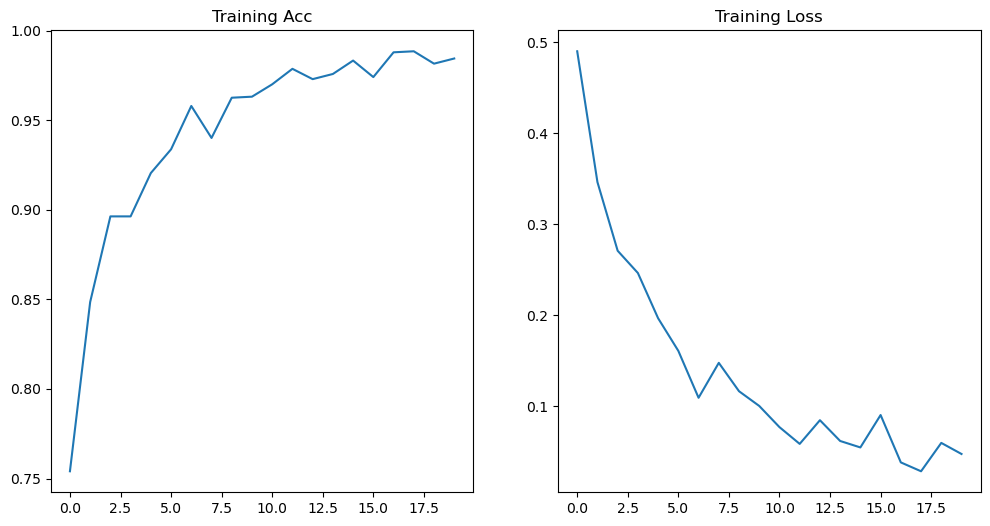

In [10]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.title('Training Acc')

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.title('Training Loss')
plt.show()

12/12 [==============================] - 3s 225ms/step
[[133  56]
 [  3 182]]


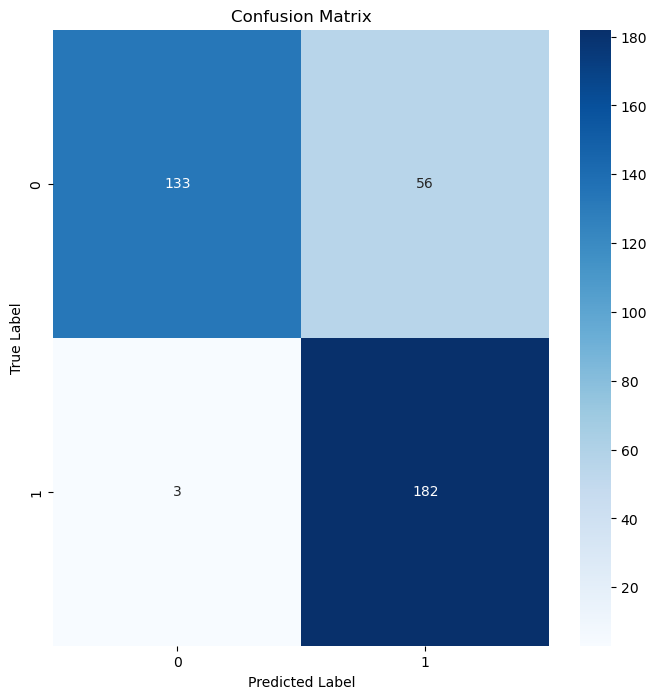

              precision    recall  f1-score   support

           0       0.98      0.70      0.82       189
           1       0.76      0.98      0.86       185

    accuracy                           0.84       374
   macro avg       0.87      0.84      0.84       374
weighted avg       0.87      0.84      0.84       374



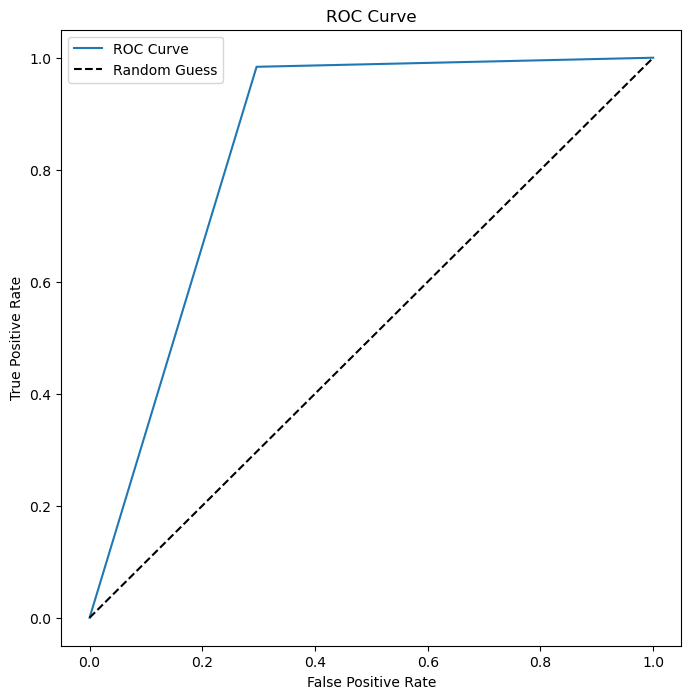

In [14]:
# display the confusion matrix
y_pred = model_base.predict(test_data)
y_pred = np.round(y_pred)
cm = confusion_matrix(test_data.classes, y_pred)
print(cm)

# plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# display the classification report
print(classification_report(test_data.classes, y_pred))

# display the ROC curve
fpr, tpr, thresholds = roc_curve(test_data.classes, y_pred)
plt.figure(figsize=(8, 8))

plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### VGG16 CNN

In [193]:
# Load the VGG16 model with pre-trained weights
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers in the model
for layer in vgg16_model.layers:
    layer.trainable = False

# Add a new classifier on top of the pre-trained model
model_vgg = tf.keras.Sequential([
    vgg16_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with binary crossentropy loss and Adam optimizer
model_vgg.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

# Define the callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True, save_weights_only=True)

# Train the model with the training data and validate on the validation data
history = model_vgg.fit(train_data, epochs=20, validation_data=val_data)
#history = model.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[early_stop, checkpoint])

model_vgg.summary()

Epoch 1/20


2023-03-21 09:21:03.851255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - ETA: 0s - loss: 0.4937 - accuracy: 0.7788

2023-03-21 09:22:29.397969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 106s 2s/step - loss: 0.4937 - accuracy: 0.7788 - val_loss: 0.2681 - val_accuracy: 0.9137
Epoch 2/20
55/55 [==============================] - 113s 2s/step - loss: 0.2424 - accuracy: 0.9147 - val_loss: 0.1690 - val_accuracy: 0.9569
Epoch 3/20
55/55 [==============================] - 98s 2s/step - loss: 0.1710 - accuracy: 0.9453 - val_loss: 0.1357 - val_accuracy: 0.9623
Epoch 4/20
55/55 [==============================] - 86s 2s/step - loss: 0.1210 - accuracy: 0.9706 - val_loss: 0.1225 - val_accuracy: 0.9677
Epoch 5/20
55/55 [==============================] - 106s 2s/step - loss: 0.0992 - accuracy: 0.9758 - val_loss: 0.1074 - val_accuracy: 0.9704
Epoch 6/20
55/55 [==============================] - 103s 2s/step - loss: 0.0801 - accuracy: 0.9827 - val_loss: 0.1036 - val_accuracy: 0.9757
Epoch 7/20
55/55 [==============================] - 103s 2s/step - loss: 0.0626 - accuracy: 0.9856 - val_loss: 0.0889 - val_accuracy: 0.9757
Epoch 8/20
55/55 [========

In [194]:
test_loss, test_acc = model_vgg.evaluate(test_data)
print("Test loss: %.3f" % test_loss)
print("Test accuracy: %.3f" % test_acc)

12/12 [==============================] - 13s 1s/step - loss: 0.0668 - accuracy: 0.9733
Test loss: 0.067
Test accuracy: 0.973


In [184]:
# save model for future use
model_vgg.save('models/model_vgg_covid_ct.h5')

In [195]:
# save model for future use
model_vgg.save('models/model_vgg_sarscov2_ctscan.h5')

### Accuracy and Loss graphs

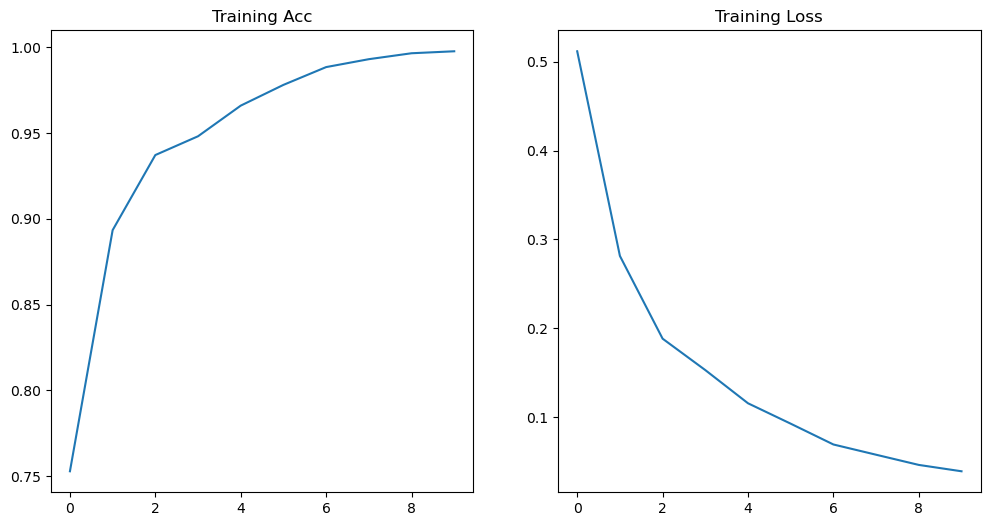

In [16]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.title('Training Acc')

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.title('Training Loss')
plt.show()

2023-03-18 10:47:08.015872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 13s 1s/step
[[184   5]
 [  4 181]]


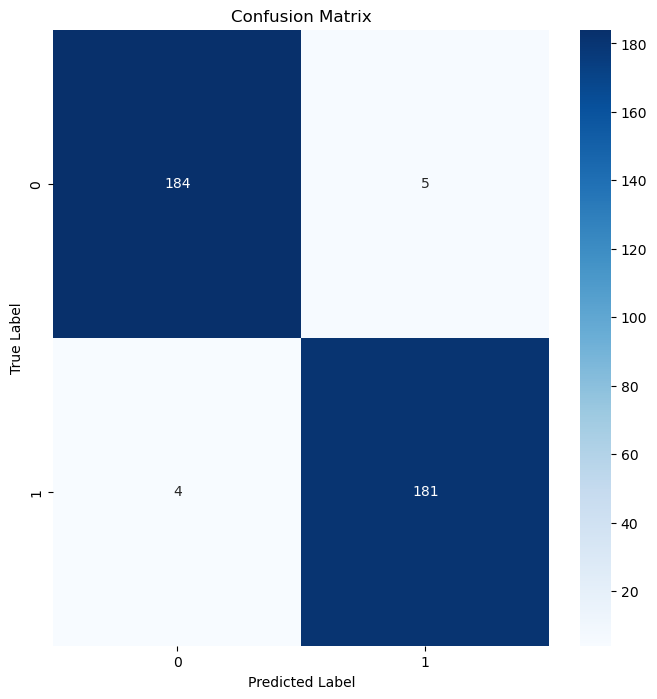

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       189
           1       0.97      0.98      0.98       185

    accuracy                           0.98       374
   macro avg       0.98      0.98      0.98       374
weighted avg       0.98      0.98      0.98       374



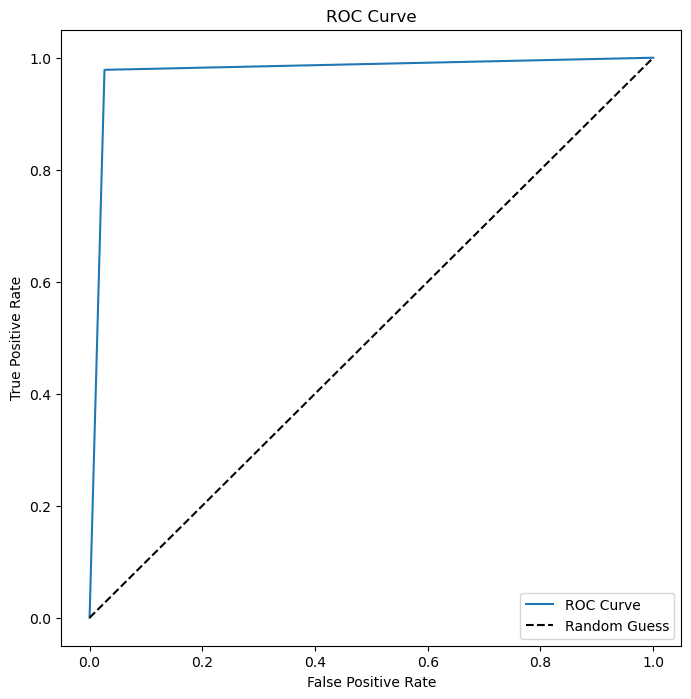

In [18]:
# display the confusion matrix
y_pred = model_vgg.predict(test_data)
y_pred = np.round(y_pred)
cm = confusion_matrix(test_data.classes, y_pred)
print(cm)

# plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# display the classification report
print(classification_report(test_data.classes, y_pred))

# display the ROC curve
fpr, tpr, thresholds = roc_curve(test_data.classes, y_pred)
plt.figure(figsize=(8, 8))

plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Cascading CNN

In [196]:
model_cascade = tf.keras.Sequential()

# First CNN block
model_cascade.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_cascade.add(MaxPooling2D((2, 2)))
model_cascade.add(Dropout(0.25))

# Second CNN block
model_cascade.add(Conv2D(64, (3, 3), activation='relu'))
model_cascade.add(MaxPooling2D((2, 2)))
model_cascade.add(Dropout(0.25))

# Third CNN block
model_cascade.add(Conv2D(128, (3, 3), activation='relu'))
model_cascade.add(MaxPooling2D((2, 2)))
model_cascade.add(Dropout(0.25))

# Flatten layer
model_cascade.add(Flatten())

# Dense layers
model_cascade.add(Dense(64, activation='relu'))
model_cascade.add(Dropout(0.5))
model_cascade.add(Dense(1, activation='sigmoid'))

# Compile the model
model_cascade.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model to the data
model_cascade.fit(train_data, epochs=20, validation_data=val_data)

model_cascade.summary()

Epoch 1/20


2023-03-21 09:59:37.067249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - ETA: 0s - loss: 1.0318 - accuracy: 0.5000

2023-03-21 09:59:59.629198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 25s 432ms/step - loss: 1.0318 - accuracy: 0.5000 - val_loss: 0.6876 - val_accuracy: 0.5040
Epoch 2/20
55/55 [==============================] - 23s 420ms/step - loss: 0.6788 - accuracy: 0.5582 - val_loss: 0.6528 - val_accuracy: 0.7871
Epoch 3/20
55/55 [==============================] - 23s 421ms/step - loss: 0.6112 - accuracy: 0.6532 - val_loss: 0.5999 - val_accuracy: 0.8194
Epoch 4/20
55/55 [==============================] - 23s 421ms/step - loss: 0.5688 - accuracy: 0.7172 - val_loss: 0.4818 - val_accuracy: 0.7978
Epoch 5/20
55/55 [==============================] - 23s 425ms/step - loss: 0.5366 - accuracy: 0.7471 - val_loss: 0.4891 - val_accuracy: 0.8221
Epoch 6/20
55/55 [==============================] - 23s 425ms/step - loss: 0.4752 - accuracy: 0.7984 - val_loss: 0.4494 - val_accuracy: 0.8625
Epoch 7/20
55/55 [==============================] - 23s 424ms/step - loss: 0.4357 - accuracy: 0.8128 - val_loss: 0.3103 - val_accuracy: 0.8787
Epoch 8/20

In [197]:
test_loss, test_acc = model_cascade.evaluate(test_data)
print("Test loss: %.3f" % test_loss)
print("Test accuracy: %.3f" % test_acc)

12/12 [==============================] - 2s 160ms/step - loss: 0.2857 - accuracy: 0.9091
Test loss: 0.286
Test accuracy: 0.909


In [187]:
# save model for future use
model_cascade.save('models/model_cascade_covid_ct.h5')

In [198]:
# save model for future use
model_cascade.save('models/model_cascade_sarscov2_ctscan.h5')

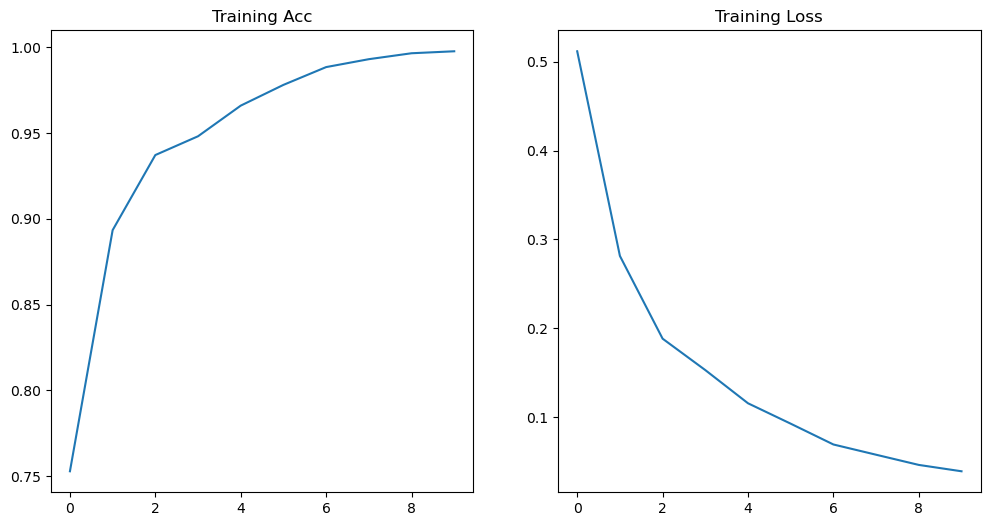

In [22]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.title('Training Acc')

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.title('Training Loss')
plt.show()

 1/12 [=>............................] - ETA: 2s

2023-03-18 10:56:33.983845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 151ms/step
[[183   6]
 [ 26 159]]


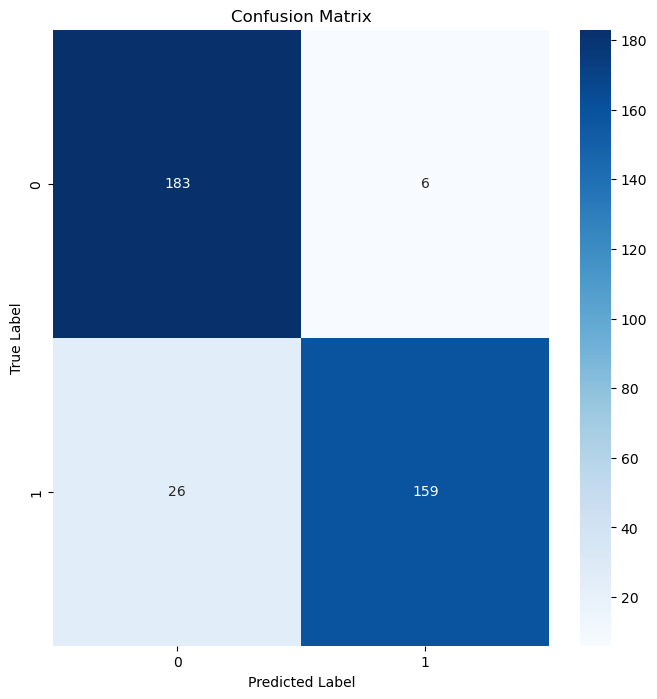

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       189
           1       0.96      0.86      0.91       185

    accuracy                           0.91       374
   macro avg       0.92      0.91      0.91       374
weighted avg       0.92      0.91      0.91       374



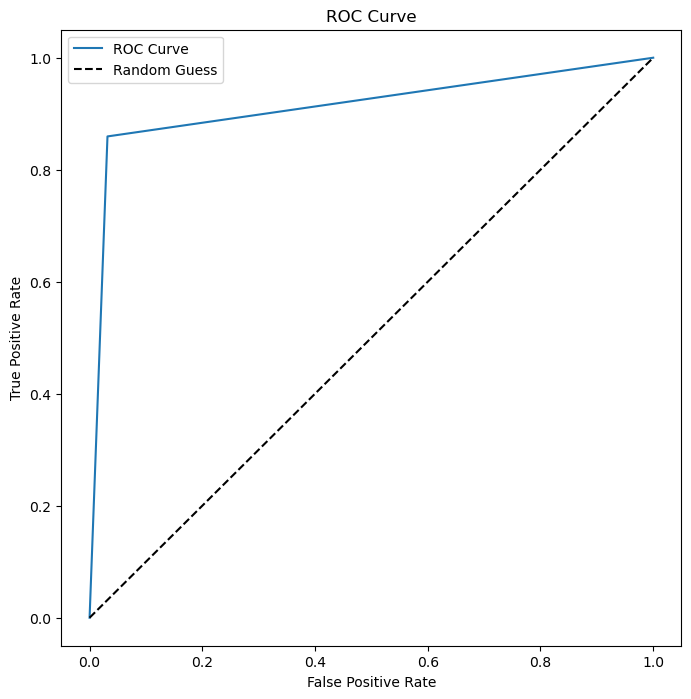

In [23]:
# display the confusion matrix
y_pred = model_cascade.predict(test_data)
y_pred = np.round(y_pred)
cm = confusion_matrix(test_data.classes, y_pred)
print(cm)

# plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# display the classification report
print(classification_report(test_data.classes, y_pred))

# display the ROC curve
fpr, tpr, thresholds = roc_curve(test_data.classes, y_pred)
plt.figure(figsize=(8, 8))

plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Testing an image prediction workflow

In [200]:
# import base model
model_base_covid_ct = load_model('models/model_base_covid_ct.h5')
# import VGG model
model_vgg_covid_ct = load_model('models/model_vgg_covid_ct.h5')
# import cascading model
model_cascade_covid_ct = load_model('models/model_cascade_covid_ct.h5')

# import base model
model_base_sarscov2_ctscan = load_model('models/model_base_sarscov2_ctscan.h5')
# import VGG model
model_vgg_sarscov2_ctscan = load_model('models/model_vgg_sarscov2_ctscan.h5')
# import cascading model
model_cascade_sarscov2_ctscan = load_model('models/model_cascade_sarscov2_ctscan.h5')

{0: 'COVID', 1: 'non-COVID'}


2023-03-21 13:39:19.046153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 417ms/step
COVID
Image name: sarscov2-ctscan-dataset/COVID/Covid (619).png
Image folder: sarscov2-ctscan-dataset/COVID


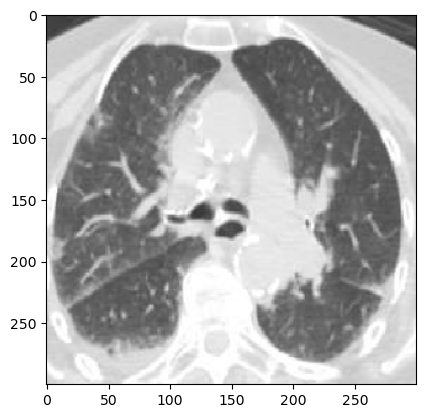

In [201]:
# define the path to your dataset
dataset_path = 'sarscov2-ctscan-dataset'

# define the labels for your classes
#class_labels = ['COVID', 'non-COVID']
#class_labels = {'COVID': 0, 'NonCOVID': 1}

class_labels = test_data.class_indices
class_labels = dict((v,k) for k,v in class_labels.items())

print(class_labels)

# create a list to hold all the images
full_dataset = []
# get all files in dataset_path
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        full_dataset.append(os.path.join(root, file))

# select random image from full_dataset
random_image = np.random.choice(full_dataset)

# get the class_labels the random image is from
folder = os.path.dirname(random_image)

# load the image
#img = cv2.imread(random_image)
img = image.load_img(random_image, target_size=(300,300))
plt.imshow(img)

# resize the image to match the input size of your model
#img = cv2.resize(img, (300, 300))

# convert the image to a numpy array
#img = np.array(img)
imp = image.img_to_array(img)

# add a dimension to the image to match the input size of your model
img = np.expand_dims(img, axis=0)

# make a prediction for the image
prediction = model_vgg_sarscov2_ctscan.predict(img)
#prediction = np.squeeze(model_vgg.predict(img))
#print(prediction)

# convert predcition to int
prediction = int(prediction.round())
#print(prediction)

# if prediction close to 0 print COVID
if prediction == 0:
    print("COVID")
# if prediction close to 1 print non-COVID
if prediction == 1:
    print("non-COVID")

# print image name
print("Image name: {}".format(random_image))

# print image folder
print("Image folder: {}".format(folder))

{0: 'COVID', 1: 'non-COVID'}
1/1 [==============================] - 0s 15ms/step
COVID
Image name: COVID-CT-master/Images-processed/CT_NonCOVID/30%0.jpg
Image folder: COVID-CT-master/Images-processed/CT_NonCOVID


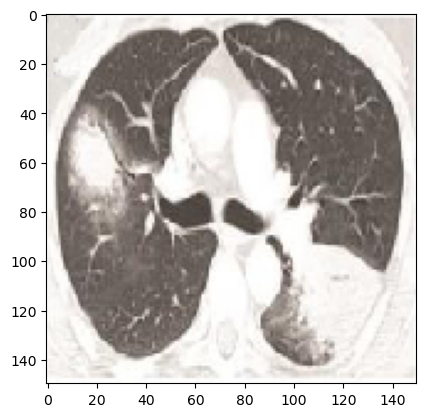

In [219]:
# define the path to your dataset
dataset_path = 'COVID-CT-master/Images-processed/'

# define the labels for your classes
#class_labels = ['CT_COVID', 'CT_NonCOVID']

class_labels = test_data.class_indices
class_labels = dict((v,k) for k,v in class_labels.items())

print(class_labels)

# create a list to hold all the images
full_dataset = []
# get all files in dataset_path
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        full_dataset.append(os.path.join(root, file))

# select random image from full_dataset
random_image = np.random.choice(full_dataset)

# get the class_labels the random image is from
folder = os.path.dirname(random_image)

# load the image
#img = cv2.imread(random_image)
img = image.load_img(random_image, target_size=(150,150))
plt.imshow(img)

# resize the image to match the input size of your model
#img = cv2.resize(img, (300, 300))

# convert the image to a numpy array
#img = np.array(img)
imp = image.img_to_array(img)

# add a dimension to the image to match the input size of your model
img = np.expand_dims(img, axis=0)

# make a prediction for the image
prediction = model_vgg_covid_ct.predict(img)
#prediction = np.squeeze(model_vgg.predict(img))
#print(prediction)

# convert predcition to int
prediction = int(prediction.round())
#print(prediction)

# if prediction close to 0 print COVID
if prediction == 0:
    print("COVID")
# if prediction close to 1 print non-COVID
if prediction == 1:
    print("non-COVID")

# print image name
print("Image name: {}".format(random_image))

# print the folder
print("Image folder: {}".format(folder))